# HOMEWORK 3

###### Submitted by - (HARDIK CHUGH)

### TASK 1

In [1]:
import concurrent.futures
import numpy as np
import pandas as pd
import time
import tqdm

<p> Let's get the datasets</p>

In [2]:
X_data_frame = pd.read_csv("data.csv")
Y_data_frame = pd.read_csv("label.csv")
X_data_frame = X_data_frame.to_numpy(dtype=float)
Y_data_frame = Y_data_frame.to_numpy(dtype=int)

In [3]:
#using Euclidean distance for distance calculation
def euclidean(value_1, value_2):
    return np.sqrt(np.sum(np.square(np.subtract(value_1, value_2))))

In [4]:
#using jaccard distance for distance calculation
def jaccard(value_1, value_2):
    return 1 - np.divide(np.sum(np.minimum(value_1, value_2)),
                         np.sum(np.maximum(value_1, value_2)))

In [5]:
#using cosine distance for distance calculation
def cosine(value_1, value_2):
    return 1 - np.divide(np.sum(np.multiply(value_1, value_2)),
                         np.multiply(np.sqrt(np.sum(np.square(value_1))),
                                     np.sqrt(np.sum(np.square(value_2)))))

In [6]:
def lists_equal(value_1, value_2):
    return np.array_equal(np.sort(value_1), np.sort(value_2))

In [7]:
def SSE(dist_func, X_data_frame, centroids):
    SSE_result = 0
    for centroid in centroids:
        for point in X_data_frame:
            SSE_result += dist_func(centroid, point)**2
    return SSE_result

In [8]:
def kMeans(distance_func, X_data_frame, Y_data_frame=[], K=0, centroids=np.array([]), stoppers=["Centroid stays the same"],
           maxIterations=0, task_id=""):

    if task_id == "task_1_stop":
        retrieve = str(distance_func.__name__) + "\t" + str(stoppers)
    else:
        retrieve = str(distance_func.__name__) + "\t"
   
    Y_data_frame_computed = np.full(X_data_frame.shape[0], 0)
   
    if len(stoppers) < 1 and maxIterations == 0:
        print("Stop criteria missing")
        return
  
    if centroids.size > 0:

        if len(centroids) != K:
            print("Mismatch: Found " + str(centroids) +
                  "Initial centroids with K = " + str(K))
 
    else:
        centroids = X_data_frame[np.random.choice(X_data_frame.shape[0], K, replace=False), :]

    start = time.time_ns()
    iterations = 0
    while True:

        old_centroids = np.copy(centroids)
        iterations += 1

        tmp_centroid_sum = np.zeros(centroids.shape)
        temp_centroid_count = np.zeros(centroids.shape[0])
    
        for point_idx, point in enumerate(X_data_frame):
            shortest_distance = float('inf')
  
            for centroid_idx, centroid in enumerate(centroids):
                distance = distance_func(point, centroid)
                if distance < shortest_distance:
                    shortest_distance = distance

                    Y_data_frame_computed[point_idx] = centroid_idx

            tmp_centroid_sum[Y_data_frame_computed[point_idx]] = np.add(
                tmp_centroid_sum[Y_data_frame_computed[point_idx]], point)

            temp_centroid_count[Y_data_frame_computed[point_idx]] += 1

        for i in range(len(centroids)):

            if temp_centroid_count[i] == 0:
                print("Centroid discovered empty during iterations " + str(iterations))

                centroids[i] = np.copy(old_centroids[i])
            else:
                centroids[i] = np.divide(tmp_centroid_sum[i],
                                         np.full(centroids.shape[1], temp_centroid_count[i]))

        if "Centroid stays the same" in stoppers and lists_equal(old_centroids, centroids):
            break #when the centroid position stays unchanged
           
        if "SSE" in stoppers and SSE(distance_func, X_data_frame, centroids) \
                > SSE(distance_func, X_data_frame, old_centroids):

            centroids = np.copy(old_centroids)
            break #if the SSE value rises in the following iteration

        if (maxIterations != 0 and iterations >= maxIterations) \
                or (maxIterations == 0 and iterations >= 500):
            break #when the maximum iteration values reaches

    end = time.time_ns()

    if task_id == "task_1":
        retrieve += "SSE = " + str(SSE(distance_func, X_data_frame, centroids)) + "\n"
        retrieve += "Predictive accuracy = " + str(accuracy(Y_data_frame, Y_data_frame_computed))
    if task_id == "task_1_stop":
        retrieve += "\t" + str(iterations) + "\t" + str(SSE(distance_func, X_data_frame, centroids)) \
            + "\t" + str(end - start) + " nano_seconds"
    return retrieve

In [9]:
def accuracy(Y_data_frame, Y_data_frame_computed):
    
    # Labeling each cluster based on the data points' labels that received the most votes.
    cluster_score = []
    for i in range(len(Y_data_frame)):
        cluster_score.insert(i, [])
        for j in range(len(Y_data_frame)):
            cluster_score[i].insert(j, 0)
    
    for i in range(len(Y_data_frame)):
        cluster_score[Y_data_frame_computed[i]][Y_data_frame[i][0]] += 1
    
    correct_cluster_score = 0
    total_cluster_score = 0
    for i in tqdm(range(len(Y_data_frame))):
        winner = 0
        maximum_seen_value = 0
        for j in tqdm(range(len(Y_data_frame))):
            if cluster_score[i][j] > maximum_seen_value:
                winner = j
                maximum_seen_value = cluster_score[i][j]
                
        for j in range(len(Y_data_frame)):
            total_cluster_score += cluster_score[i][j]
            if j == winner:
                correct_cluster_score += cluster_score[i][j]
    return ((correct_cluster_score / total_cluster_score) * 100)

In [ ]:
def main():
    
    '''
    X_data_frame = pd.read_csv("data.csv")
    Y_data_frame = pd.read_csv("label.csv")
    X_data_frame = X_data_frame.to_numpy(dtype=float)
    Y_data_frame = Y_data_frame.to_numpy(dtype=int)
    '''
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=24) as executor:
        
        future_process = []
        
        # TASK 1 -> Q1 and Q2
        future_process.append(executor.submit(
            kMeans, euclidean, X_data_frame, Y_data_frame=Y_data_frame, K=8, task_id="task_1"))
        future_process.append(executor.submit(
            kMeans, cosine, X_data_frame, Y_data_frame=Y_data_frame, K=8, task_id="task_1"))
        future_process.append(executor.submit(
            kMeans, jaccard, X_data_frame, Y_data_frame=Y_data_frame, K=8, task_id="task_1"))

        # TASK 1 -> Q3
        future_process.append(executor.submit(kMeans, euclidean, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, maxIterations=100, stoppers=["Centroid stays the same", "SSE"], task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, cosine, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, maxIterations=100, stoppers=["Centroid stays the same", "SSE"], task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, jaccard, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, maxIterations=100, stoppers=["Centroid stays the same", "SSE"], task_id="task_1_stop"))

        # TASK 1 -> Q4
        # Running K_means for the no change in centroid
        future_process.append(executor.submit(kMeans, euclidean, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=["Centroid stays the same"], task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, cosine, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=["Centroid stays the same"], task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, jaccard, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=["Centroid stays the same"], task_id="task_1_stop"))

        # Running K_means for when the SSE value increases in the next iteration
        future_process.append(executor.submit(kMeans, euclidean, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=["SSE"], task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, cosine, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=["SSE"], task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, jaccard, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=["SSE"], task_id="task_1_stop"))

        # Running K_means till the maximum iteration occurs
        future_process.append(executor.submit(kMeans, euclidean, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=[], maxIterations=100, task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, cosine, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=[], maxIterations=100, task_id="task_1_stop"))
        future_process.append(executor.submit(kMeans, jaccard, X_data_frame, Y_data_frame=Y_data_frame,
                       K=8, stoppers=[], maxIterations=100, task_id="task_1_stop"))

        
        future_iterations = iter(future_process)

        print("\nTask Q1 and Task Q2 \n")
        print(next(future_iterations).result())
        print("\n")
        print(next(future_iterations).result())
        print("\n")
        print(next(future_iterations).result())

        print("\nTask Q3 \n")
        print("Distance\tStopping Criteria\t\t\tIterations\tSSE\tTime")
        print("\n")
        print(next(future_iterations).result())
        print(next(future_iterations).result())
        print(next(future_iterations).result())

        print("\nTask Q4 \n")
        print("Distance\tStopping Criteria\t\t\tIterations\tSSE\tTime")
        print("\n")
        print(next(future_iterations).result())
        print(next(future_iterations).result())
        print(next(future_iterations).result())
        print("\n")
        print(next(future_iterations).result())
        print(next(future_iterations).result())
        print(next(future_iterations).result())
        print("\n")
        print(next(future_iterations).result())
        print(next(future_iterations).result())
        print(next(future_iterations).result())

if __name__ == "__main__":
    main()


Task Q1 and Task Q2 



In [10]:
%run kmeans.py


Task Q1 and Task Q2 

euclidean	SSE = 343547585673.04956
Predictive accuracy = 57.845784578457845


cosine	SSE = 17543.346332699988
Predictive accuracy = 58.58585858585859


jaccard	SSE = 44431.99816048491
Predictive accuracy = 49.41494149414942

Task Q3 

Distance	Stopping Criteria			Iterations	SSE	Time


euclidean	['Centroid stays the same', 'SSE']	2	337584891087.623	18677185500 nano_seconds
cosine	['Centroid stays the same', 'SSE']	2	16417.375466743146	49928656400 nano_seconds
jaccard	['Centroid stays the same', 'SSE']	3	44143.57732797095	53869720900 nano_seconds

Task Q4 

Distance	Stopping Criteria			Iterations	SSE	Time


euclidean	['Centroid stays the same']	92	344214166473.02136	209505436700 nano_seconds
cosine	['Centroid stays the same']	54	17656.917760426306	273617865200 nano_seconds
jaccard	['Centroid stays the same']	51	44297.88548786344	209065436300 nano_seconds


euclidean	['SSE']	2	328084764528.46375	24928269700 nano_seconds
cosine	['SSE']	2	15866.366026458665	4778965680

### TASK 2

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.display import Image
init_notebook_mode(connected=True)
%matplotlib inline

import surprise
from surprise import KNNBasic
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans

In [12]:
rating_small_df = pd.read_csv("ratings_small.csv")
rating_small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


<h3><b>(A) </b>Reading data using the following line format from "ratings small.csv": "userID movieID rating timestamp"</h3>

In [13]:
reader = Reader(rating_scale=(1, 5))
refined_data = Dataset.load_from_df(rating_small_df[['userId', 'movieId', 'rating']], reader)

<h3>(B) Mean Absolute Error and Root Mean Square Error</h3>

$$
\begin{align}
  MAE = \frac{\sum_{i=1}^{n} \lvert y_{i} - x_{i} \rvert}{n} = \frac{\sum_{i=1}^{n}\lvert e_{i} \rvert}{n}
\end{align}
$$
$$
\begin{align}
  RMSE = \sqrt{\frac{\sum_{i=1}^{n} (\hat{y_{i}} - y_{i})^2}{n}}
\end{align}
$$

<h3>(C) Compute the average MAE and RMSE of the Probabilistic Matrix Factorization (PMF), User based Collaborative Filtering, Item based Collaborative Filtering, under the 5-folds cross-validation</h3>

In [14]:
import warnings 

warnings.filterwarnings("ignore")

compare_matrix = []

#Cross-validation 5-Fold
for algorithm in [SVD(biased=False), KNNBasic(sim_options = {'user_based': True }), KNNBasic(sim_options = {'user_based': False})]:
    
    Cross_validation_results = cross_validate(algorithm, refined_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    tempo = pd.DataFrame.from_dict(Cross_validation_results).mean(axis=0)
    tempo = tempo.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))

    compare_matrix.append(tempo)
    print("\n")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0051  1.0001  1.0221  1.0098  1.0041  1.0082  0.0076  
MAE (testset)     0.7751  0.7723  0.7884  0.7830  0.7715  0.7781  0.0066  
Fit time          1.38    1.44    1.58    1.42    1.41    1.45    0.07    
Test time         0.31    0.18    0.31    0.16    0.16    0.23    0.07    


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9581  0.9644  0.9626  0.9769  0.9773  0.9678  0.00

<h3>(D) Let us compare the average (mean) performances of User-based collaborative filtering, item-based collaborative filtering, PMF with respect to RMSE and MAE. </h3>

In [15]:
compare_matrix = pd.DataFrame(compare_matrix)
Algo_1 = ['PMF','User-basedCF','Item-basedCF']
compare_matrix['Algorithm'] = Algo_1
compare_matrix

,test_rmse,test_mae,fit_time,test_time,Algorithm
0,1.008233,0.778070,1.446362,0.225595,PMF
1,0.967832,0.743664,0.249001,1.748222,User-basedCF
2,0.934801,0.720907,3.448648,8.065880,Item-basedCF


<h3>(E) Examine how the cosine, MSD (Mean Squared Difference), and Pearson 
similarities impact the performances of User based Collaborative Filtering and 
Item based Collaborative Filtering.</h3>

In [16]:
import tqdm
benchmark_similarity = []

#Cross-validation 5-Fold
for algorithm in [  KNNBasic(sim_options = {'name':'cosine','user_based': True}), 
                    KNNBasic(sim_options = {'name':'MSD', 'user_based':True }),
                    KNNBasic(sim_options = {'name':'pearson','user_based': True}),
                    KNNBasic(sim_options = {'name':'cosine', 'user_based':False }),
                    KNNBasic(sim_options = {'name':'MSD', 'user_based':False }),
                    KNNBasic(sim_options = {'name':'pearson','user_based': False})]:
    
    Cross_validation_results = cross_validate(algorithm, refined_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    tempo = pd.DataFrame.from_dict(Cross_validation_results).mean(axis=0)
    pd.concat([tempo, (pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))])
    
    benchmark_similarity.append(tempo)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson si

In [17]:
benchmark_1 = pd.DataFrame(benchmark_similarity)
algorithm_2 = ['Cosine_User-basedCF','MSD_User-basedCF','Pearson_User-basedCF','Cosine_Item-basedCF','MSD_Item-basedCF','Pearson_Item-basedCF']
benchmark_1['Algorithm'] = algorithm_2

comparison_similarity = benchmark_1.set_index('Algorithm').sort_values('Algorithm', ascending=False)
comparison_similarity

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
Pearson_User-basedCF,0.998139,0.772772,0.521317,1.293918
Pearson_Item-basedCF,0.988976,0.767607,9.129463,8.516963
MSD_User-basedCF,0.968355,0.744489,0.231399,1.610231
MSD_Item-basedCF,0.934012,0.720812,3.307552,8.148309
Cosine_User-basedCF,0.993979,0.767860,0.652800,1.782228
Cosine_Item-basedCF,0.994366,0.773704,8.004975,8.695778


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

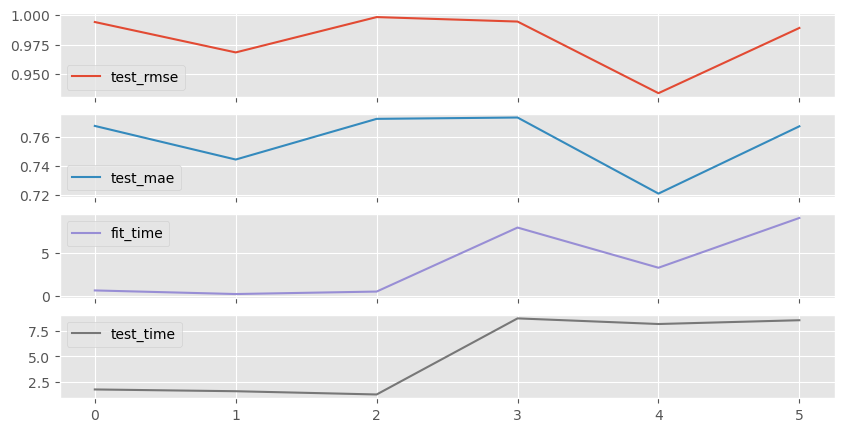

In [18]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
benchmark_1.plot(subplots=True, figsize=(10,5))

<h3>(F) Examining how the number of neighbors impacts the performances of User-based Collaborative Filtering and Item-based Collaborative Filtering</h3>

<h3>Collaborative User-based Filtering</h3>

In [19]:
benchmark_ucf = []

for i in range(1,30):

    algorithm =KNNBasic(k=i, sim_options = {'name':'MSD','user_based': True})
    results = cross_validate(algorithm, refined_data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)

    benchmark_ucf.append(temp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

<h3>Collaborative Item-based Filtering</h3>

In [20]:
benchmark_icf = []

for i in range(1,30):
    #{'user_based': False} for item-based
    algorithm =KNNBasic(k=i, sim_options = {'name':'MSD','user_based': False})
    results = cross_validate(algorithm, refined_data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    temp = pd.DataFrame.from_dict(results).mean(axis=0)

    benchmark_icf.append(temp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [21]:
benchmark_ucf = pd.DataFrame(benchmark_ucf)
benchmark_icf = pd.DataFrame(benchmark_icf)

u_rmse = benchmark_icf['test_rmse']
i_rmse = benchmark_ucf['test_rmse']

u_mae = benchmark_icf['test_mae']
i_mae = benchmark_ucf['test_mae']

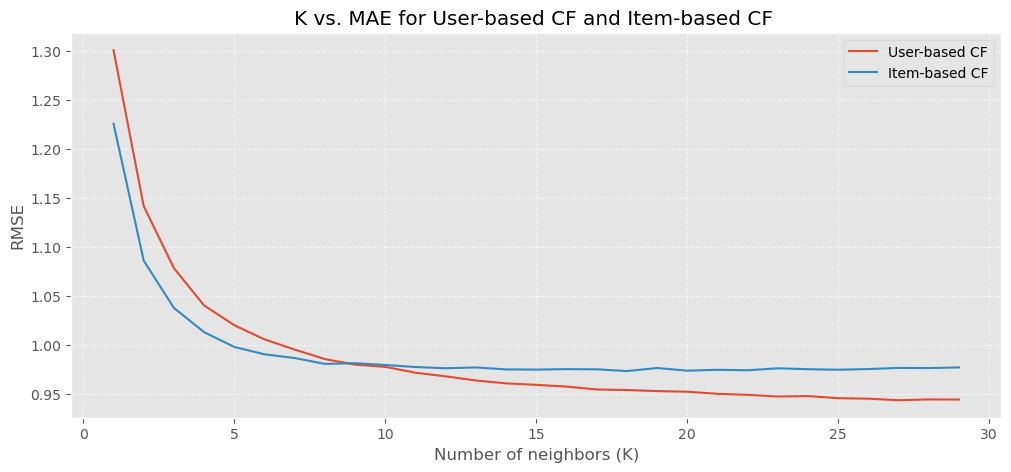

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(range(1,30), u_rmse, label = "User-based CF")
plt.plot(range(1,30), i_rmse, label = "Item-based CF")
plt.title('')
plt.xlabel('Number of neighbors (K)')
plt.ylabel('RMSE')

plt.title('K vs. MAE for User-based CF and Item-based CF ')
plt.legend(loc='best')
plt.grid(ls='dotted')

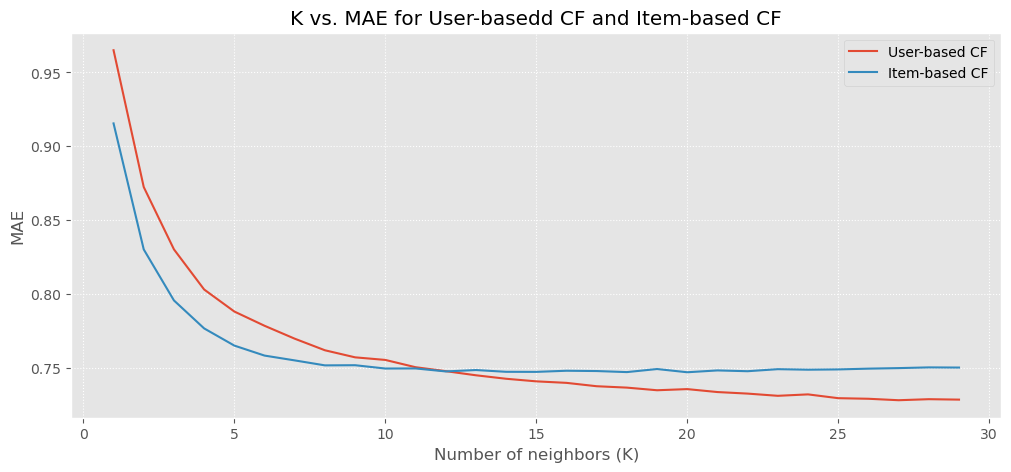

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(range(1,30), u_mae, label = "User-based CF")
plt.plot(range(1,30), i_mae, label = "Item-based CF")
plt.title('')
plt.xlabel('Number of neighbors (K)')
plt.ylabel('MAE')

plt.title('K vs. MAE for User-basedd CF and Item-based CF')
plt.legend(loc='best')
plt.grid(ls='dotted')


<h3>(G) Identifying the best number of neighbor (denoted by K) for User/Item based collaborative filtering in terms of RMSE</h3>

In [24]:
print("For User-based CF, the best number of neighbours K =" , u_rmse.idxmin()+1, "with minimum RMSE:", min(u_rmse))
print("For Item-based CF, the best number of neighbours K =" , i_rmse.idxmin()+1 , "with minimum RMSE:", min(i_rmse))
print("For User-based CF, the best number of neighbours K =" , u_rmse.idxmin()+1, "with minimum MAE:", min(u_mae))
print("For Item-based CF, the best number of neighbours K =" , i_rmse.idxmin()+1 , "with minimum MAE:", min(i_mae))

For User-based CF, the best number of neighbours K = 27 with minimum RMSE: 0.9435889095455677
For Item-based CF, the best number of neighbours K = 18 with minimum RMSE: 0.9733521139583167
For User-based CF, the best number of neighbours K = 27 with minimum MAE: 0.7280357952662718
For Item-based CF, the best number of neighbours K = 18 with minimum MAE: 0.7469756273110549
